In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

## First we say what query and project we are interested in

In [3]:
pid = 217
qid = 7966
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

94944


94944

### And we retrieve those documents that have been screened in that query

In [37]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

94944


483

### We have a separate list of documents in the query that have not been screened

In [5]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(94461, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,4,"In America, entertainment celebrities have ent...","From sidekick to sideshow - Celebrity, enterta...",politics of distraction; celebrity politics; c...,"[Psychology, Clinical; Social Sciences, Interd...",0,0
1,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
2,29,In an stylized endogenous growth economy with ...,Optimal green tax reforms yielding double divi...,Double dividend; Emissions tax; Dynamic Laffer...,[Economics; Energy & Fuels; Environmental Scie...,0,0
3,65,The world's increasing need is to develop smar...,Synthesis of a Cementitious Material Nanocemen...,None,[Nanoscience & Nanotechnology; Materials Scien...,0,0
4,74,Numerous epidemiological studies have demonstr...,Particulate matter in the indoor air of classr...,indoor; schools; classrooms; particulate matte...,[Environmental Sciences; Meteorology & Atmosph...,0,0


### We gather the screening decisions (relevant=1, not relevant=0) and make a dataframe from them

In [6]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(483, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,6212,"Carbon (C) sequestration, defined as the proce...",Mechanisms of C sequestration in soils of Lati...,carbon sequestration; soil organic carbon; soi...,[Plant Sciences],1,1
1,11056,"Between 2005 and 2010, 6.3 million migrants (a...",The Influence of Internal Migration on Exposur...,Climate change; environment; exposure; Mexico;...,[Development Studies; Environmental Studies; R...,1,1
2,31242,1. Rates of methanogenesis in freshwater sedim...,Phytoplankton lipid content influences freshwa...,eutrophication; lakes; lipid; methane; phytopl...,[Ecology; Marine & Freshwater Biology],0,1
3,34465,Eutrophication of lakes and the risk of harmfu...,"Climate change, cyanobacteria blooms and ecolo...",Phytoplankton; Biological indicators; Eutrophi...,[Ecology],1,1
4,42249,The North American Regional Reanalysis (NARR) ...,NARR's Atmospheric Water Cycle Components. Par...,None,[Meteorology & Atmospheric Sciences],0,1


### And we merge the two, with a column "seen" recording if a document has been seen or not

In [7]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,272872,Semi-sessile Mytilus mussels are used as indic...,A first report on coexistence and hybridizatio...,Mytilus edulis; M. trossulus; Population struc...,[Biodiversity Conservation; Ecology],0,0
1,1060263,Empirical findings on actors' roles and respon...,The Stimuli-Actions-Effects-Responses (SAER)-f...,Climate change perception; Private adaptation;...,[Environmental Sciences],0,0
2,266357,"In the UK, the Standard Assessment Procedure (...",Key factors determining the energy rating of e...,building stock; energy rating; global sensitiv...,[Construction & Building Technology],0,0
3,773692,This paper investigates the performance of an ...,Performance analysis of an experimental smart ...,Zero-carbon emissions; Green buildings; Built ...,[Thermodynamics; Energy & Fuels],0,0
4,647574,Equitable access to sustainable development (E...,Equitable access to sustainable development: o...,burden sharing; equity; mitigation; sustainabl...,[Environmental Studies; Public Administration],0,0


### We also get the assignments of these documents to categories, and add these as further columns in our dataframe

In [13]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

df = pd.merge(df, cat_map, how="left").fillna(0)
print(df.shape)
df.head()

category__name,id,Adaptation,Governance & policies,Government procurement & public services,Information,Mitigation,Other,Regulation,Subsidies,tax/emission trading,voluntary agreement
0,6212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,11056,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,34465,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,46961,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,62159,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### We have a look at the distribution of relevant and not relevant documents

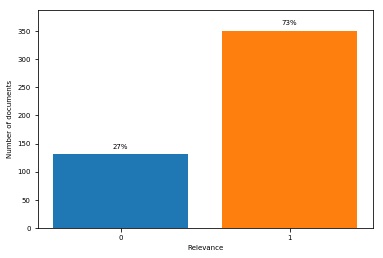

In [42]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams)

In [22]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=20, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

ab_X = vec.fit_transform(df['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### We build 3 types of classifiers, and test these with k-fold cross validation

In [26]:
from sklearn.model_selection import KFold
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


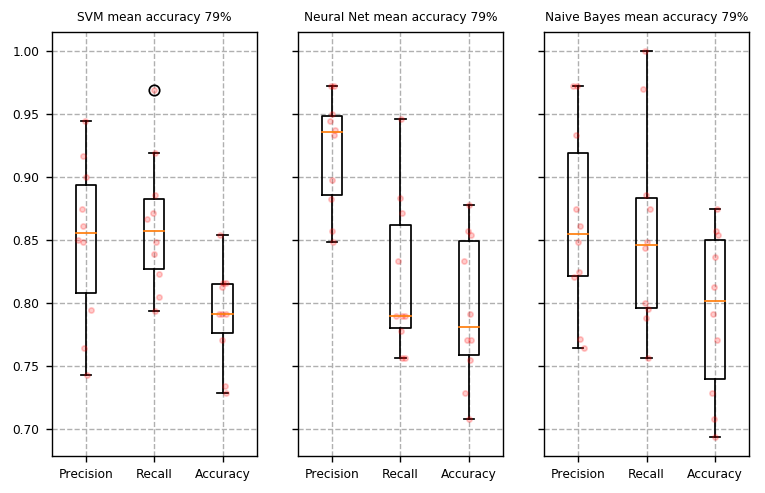

In [27]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        y = model[s]
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax.plot(x, y, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

### We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [43]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

73341 out of 94461 documents are predicted to be relevant


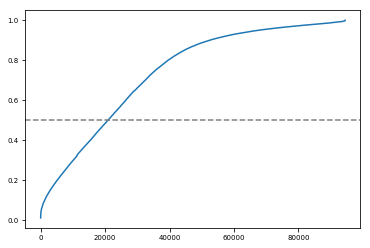

In [45]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

plt.show()

### Now we make a new random sample

In [46]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

In [54]:
t1, created = Tag.objects.get_or_create(
    title="random sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 1000
docs_added = 0
for i, row in df[df['seen']==0].sample(frac=1).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  
            
t1.update_tag()

## Now we try and predict mitigation

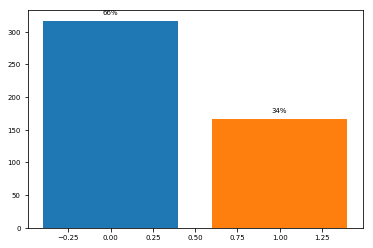

In [55]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(df[df['seen']==1].groupby('Governance & policies')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [56]:
y = df['Governance & policies']
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


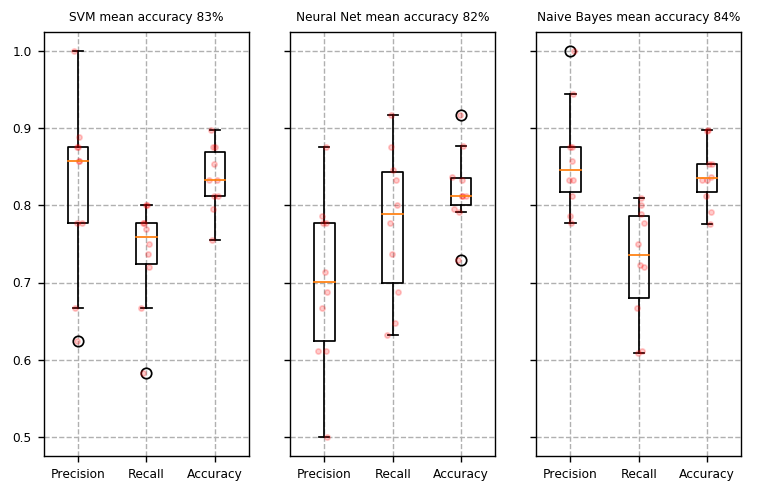

In [57]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        ys = model[s]
        x = np.random.normal(i+1, 0.04, size=len(ys))
        ax.plot(x, ys, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [61]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

36045
94461


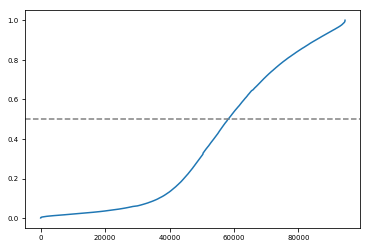

In [62]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

### Now we can make a new tag and screening decision objects with the x documents most likely to be relevant

In [63]:
q = Query.objects.get(pk=qid)
q.users.all()

<QuerySet [<User: minj>, <User: maowenxin2014@163.com>]>

In [68]:
import datetime


t1 = Tag(
    title="predicted policy sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  

    
t1.update_tag()


In [67]:
df[['id','prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)